In [1]:
# Modified by Hoik Jang   Last Modified :  2023/08/01

In [1]:
####################################################################################################
###### Import Packages
####################################################################################################

import os
import warnings
import pickle
import numpy as np
import torch
import time
warnings.filterwarnings("ignore")  # avoid printing out absolute paths
# os.chdir("../../..")
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import pandas as pd
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss, RMSE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


import gc
import holoviews as hv
from holoviews import opts
hv.extension('matplotlib')

In [ ]:
####################################################################################################
###### Model Labeling
####################################################################################################

start_model_time      = time.time()
model_type            = 'tft_1hour_sum_light'
model_type_ver        = 'v1'
time_interval         = '1hour'
accelerator           = "gpu"
seed                  = 529
batch_size            = 128  # set this between 32 to 128
max_epochs            = 500
patience              = 20
max_encoder_length    = 480  #val과 train의 차이값
max_prediction_length = 24
time_split            = '2023060100'
pl.seed_everything(seed)

In [3]:
####################################################################################################
###### Load Data
####################################################################################################

start_model_time              = time.time()
df_data                       = pd.read_pickle("base_mart_busanjin_full_build.pkl")
df_data['dayofweek']          = df_data['dayofweek'].astype(str)
df_data['holiday']            = df_data['holiday'].astype(str)
df_data= df_data.drop(columns = ['id','lt_x','lt_y','rb_x','rb_y','lat_label','lng_label','date'])
df_data['cust_id_idx']        = df_data['cust_id'].factorize()[0]
df_data_input                 = df_data.loc[df_data['datetime']<=time_split]


In [22]:
####################################################################################################
###### Create Dataset and Dataloaders
####################################################################################################


training_cutoff       = df_data_input["time_step"].max() - max_prediction_length

training              = TimeSeriesDataSet(
     df_data_input[lambda x: x.time_step <= training_cutoff]
    ,time_idx              = "time_step"
    ,target                = "build_sum_count"
    ,group_ids             = ["cust_id_idx"]
    ,min_encoder_length    = max_encoder_length // 2  # keep encoder length long (as it is in the validation set)
    ,max_encoder_length    = max_encoder_length
    ,min_prediction_length = 1
    ,max_prediction_length = max_prediction_length

   
    #범주형 변수
    #시간이 지나도 변하지 않는 범주형 변수(제품카테고리 등)
    #static_categoricals=["id"],
    
    #시간이 지나도 변하지 않는 연속 변수 목록
    #static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    
    #미래에 알려져있는 카테고리 변수(이벤트성 변수)
    ,time_varying_known_categoricals = ["dayofweek", "holiday","year", "month", "day","hour"]
    
    
    # variable_groups (Dict[str, List[str]]): 이름을 데이터의 열 목록에 매핑하는 dic.
    # 이름이 있어야 합니다.
    # 범주형 또는 실제 클래스 인수에서 그룹별로 열을 인코딩하거나 확장할 수 있습니다.
    # 이렇게 하면 범주형 변수를 효과적으로 결합할 수 있으며 범주형 변수가 다음과 같은 경우에 특히 유용합니다.
    # 동시에 여러 값을 가질 수 있습니다. 중복될 수 있는 공휴일이 그 예입니다.
    
#     variable_groups = {"special_days": special_days},  # group of categorical variables can be treated as one variable
    

#     time_varying_known_reals (List[str]): 변경되는 연속 변수 목록
#         시간과 미래에 알려짐(예: 제품의 가격이지만 제품의 수요는 아님)
    ,time_varying_known_reals          = ["time_step", "temp", "rainamount","datetime"]
    ,time_varying_unknown_categoricals = []
    
    #미래에 알려지지 않는 변수를 입력하는 듯
    ,time_varying_unknown_reals        = ["build_sum_count"]
    
    #정규화하기위핸 타겟 정의
    ,target_normalizer                 = GroupNormalizer(groups=["cust_id_idx"], transformation=None)  # use softplus and normalize by group
    
#     target_normalizer=pf.data.encoders.NaNLabelEncoder(),
    ,add_relative_time_idx    = True
    ,add_target_scales        = True
    ,add_encoder_length       = True
    ,allow_missing_timesteps  = True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation                    = TimeSeriesDataSet.from_dataset(training, df_data_input, predict=True, stop_randomization=True)

# create dataloaders for model

train_dataloader              = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader                = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [23]:
####################################################################################################
###### Baseline Prediction
####################################################################################################

# calculate baseline root mean squared error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
baseline_rmse        = RMSE()(baseline_predictions.output, baseline_predictions.y)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(218.5573, device='cuda:0')

In [24]:
####################################################################################################
###### Find optimal learning rate
####################################################################################################

# configure network and trainer

trainer = pl.Trainer(
     accelerator       = accelerator
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    ,gradient_clip_val = 0.1,
)


tft = TemporalFusionTransformer.from_dataset(
     training
    # not meaningful for finding the learning rate but otherwise very important
    ,learning_rate=0.03
    ,hidden_size=8  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    ,attention_head_size=1
    ,dropout=0.1  # between 0.1 and 0.3 are good values
    ,hidden_continuous_size=8  # set to <= hidden_size
    ,loss=QuantileLoss()
    ,optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


Global seed set to 42


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 11.1k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|██████████| 100/100 [00:31<00:00,  3.22it/s]
Learning rate set to 0.06760829753919811
Restoring states from the checkpoint path at /mnt/d/work/pinetree/사고예측/유동인구/workspace/.lr_find_e0739a44-3675-4825-88fd-a4987523aad4.ckpt
Restored all states from the checkpoint at /mnt/d/work/pinetree/사고예측/유동인구/workspace/.lr_find_e0739a44-3675-4825-88fd-a4987523aad4.ckpt


suggested learning rate: 0.06760829753919811


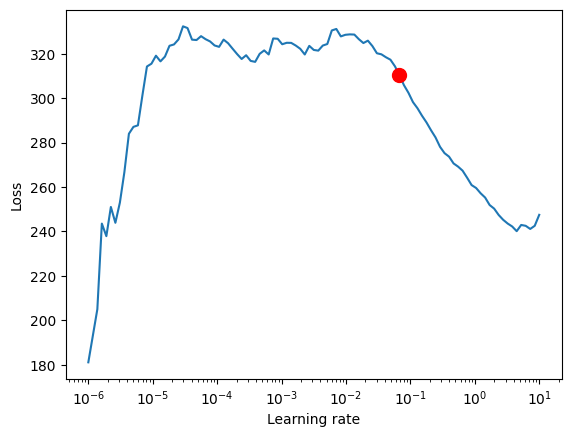

In [25]:
# find optimal learning rate


res = Tuner(trainer).lr_find(
    tft
    ,train_dataloaders=train_dataloader
    ,val_dataloaders=val_dataloader
    ,max_lr=10.0
    ,min_lr=1e-6
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [26]:
####################################################################################################
###### Model Configuration
####################################################################################################

# configure network and trainer
early_stop_callback = EarlyStopping(monitor = "val_loss", min_delta = 1e-4, patience = patience, verbose = False, mode = "min")
lr_logger           = LearningRateMonitor()  # log the learning rate
logger              = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
     max_epochs           = max_epochs
    ,accelerator          = accelerator
    ,enable_model_summary = True
    ,gradient_clip_val    = 0.01
    ,limit_train_batches  = 10  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    ,callbacks            = [lr_logger, early_stop_callback]
    ,logger               = logger
)

tft = TemporalFusionTransformer.from_dataset(
     training
    ,learning_rate              = res.suggestion()
    ,hidden_size                = 16
    ,attention_head_size        = 2
    ,dropout                    = 0.1
    ,hidden_continuous_size     = 8
    ,loss                       = QuantileLoss()
    ,log_interval               = 10  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    ,optimizer                  = "Ranger"
    ,reduce_on_plateau_patience = 4
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 25.7k


In [27]:
####################################################################################################
###### Model Training
####################################################################################################
start_train_time              = time.time()
trainer.fit(
     tft
    ,train_dataloaders=train_dataloader
    ,val_dataloaders=val_dataloader
)
end_train_time                = time.time()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 604   
3  | prescalers                         | ModuleDict                      | 144   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.1 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 4.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Epoch 103: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s, v_num=40, train_loss_step=48.60, val_loss=19.40, train_loss_epoch=36.60]


In [28]:
####################################################################################################
###### Model Validation
####################################################################################################

# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft        = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
# calcualte mean absolute error on validation set
predictions     = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="gpu"), return_x=True)
val_rmse        = RMSE()(predictions.output, predictions.y)

In [30]:
####################################################################################################
###### Model Prediction
####################################################################################################

# select last 60 months from data (max_encoder_length is 24)
encoder_data        = df_data_input[lambda x: x.time_step > x.time_step.max() - max_encoder_length]
decoder_start       = encoder_data['time_step'].max() + 1
decoder_end         = encoder_data['time_step'].max() + max_prediction_length
decoder_data        = df_data[(df_data['time_step'] >= decoder_start) & (df_data['time_step'] <= decoder_end)]
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
new_raw_predictions = best_tft.predict(new_prediction_data, mode="raw", return_x=True)
end_modeling_time   = time.time()
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=idx, show_future_observed=False)

In [34]:
####################################################################################################
###### Result Data Processing
####################################################################################################

real_encoder_lengths   = new_raw_predictions.x['encoder_lengths'].squeeze().tolist()
real_groups            = new_raw_predictions.x['groups'].squeeze().tolist()
real_output            = new_raw_predictions.output['prediction'].squeeze().tolist()
real_result            = pd.DataFrame({'encoder_lengths' : real_encoder_lengths, 'groups' : real_groups, 'output' : real_output})
real_result            = pd.concat([real_result, pd.DataFrame(real_result['output'].apply(pd.Series).values)], axis=1).drop('output', axis = 1)
stacked_df             = new_raw_predictions.output['prediction'].squeeze().tolist()
stacked_df             = pd.DataFrame(stacked_df)
stacked_df             = stacked_df.explode(stacked_df.columns.tolist()).reset_index().rename({'index' : 'cust_id_idx'}, axis=1)
stacked_df['quantile'] = stacked_df.groupby('cust_id_idx').cumcount() + 1

In [38]:
####################################################################################################
###### Result Data Transformation for Visualization
####################################################################################################

df_tft_result = pd.melt(stacked_df,id_vars=['cust_id_idx','quantile'],var_name=f'time_step_{time_interval}',value_name='sum_count')
with open(f'{model_type}_{model_type_ver}_pred.pkl', 'wb') as f:
    pickle.dump(df_tft_result, f)


In [ ]:
####################################################################################################
###### Result Record Track 
####################################################################################################
list_test_cmprsn.append([model_type
                        ,model_type_ver
                        ,baseline_rmse
                        ,val_rmse
                        ,np.mean(msleloss)
                        ,time_interval
                        ,seed
                        ,max_encoder_length
                        ,max_prediction_length
                        ,batch_size
                        ,max_epochs
                        ,patience
                        ,res.suggestion()
                        ,time_split
                        ,(end_train_time-start_train_time)
                        ,(end_model_time-start_model_time)])

In [ ]:
####################################################################################################
###### Result Data Visualization
####################################################################################################

df_pred_tft_base                 = pd.read_pickle(f'{model_type}_{model_type_ver}_pred.pkl')
df_pred_tft                      = df_pred_tft_base.loc[df_pred_tft_base['quantile']==4]

In [ ]:
time_interval                             = '1hour'
aggr                                      = 'sum'
model_type                                = time_interval+'_'+aggr + '_' + 'light' + '_' + 'build'
time_split                                = '2023060100'
df_data                                   = pd.read_pickle(f'base_input_fltpop_{model_type}.pkl')[['datetime',f'time_step_{time_interval}','lat_label','lng_label',f'build_sum_count','cust_id','cust_id_idx']]
time_split_idx                            = int(df_data.loc[(df_data['datetime']==time_split)][f'time_step_{time_interval}'].drop_duplicates())
df_latlng_table                           = df_data[['lat_label','lng_label','cust_id','cust_id_idx']].drop_duplicates()

df_pred_tft_sub                           = df_pred_tft.merge(df_latlng_table)[[f'time_step_{time_interval}','lat_label','lng_label',f'sum_count']].sort_values(by=[f'time_step_{time_interval}','lat_label','lng_label'])

df_data_sub                               = df_data.loc[(df_data[f'time_step_{time_interval}']>=time_split_idx) & (df_data[f'time_step_{time_interval}']<time_split_idx+len(df_pred_tft[f'time_step_{time_interval}'].drop_duplicates())) ]
df_data_sub[f'time_step_{time_interval}'] = df_data_sub[f'time_step_{time_interval}'] - time_split_idx
df_data_sub                               = df_data_sub[[f'time_step_{time_interval}','lat_label','lng_label',f'build_sum_count']].drop_duplicates().sort_values(by=[f'time_step_{time_interval}','lat_label','lng_label'])

length = len(df_data_sub[f'time_step_{time_interval}'].drop_duplicates())
height = len(df_data_sub['lat_label'].drop_duplicates())
width  = len(df_data_sub['lng_label'].drop_duplicates())

np_pred_plot   = np.full((length, height, width,1),0)
np_true_plot   = np.full((length, height, width,1),0)
np_true        = df_data_sub.drop_duplicates().to_numpy()
np_pred        = df_pred_tft_sub.drop_duplicates().to_numpy()

for i in range(np_true.shape[0]):
    time_idx1   = np_true[i][0]
    lat_idx1    = np_true[i][1]
    lng_idx1    = np_true[i][2]
    fltpop_val1 = np_true[i][3]
    np_true_plot[int(time_idx1),int(lat_idx1),int(lng_idx1),:] = fltpop_val1

for i in range(np_pred.shape[0]):
    time_idx2   = np_pred[i][0]
    lat_idx2    = np_pred[i][1]
    lng_idx2    = np_pred[i][2]
    fltpop_val2 = np_pred[i][3]
    np_pred_plot[int(time_idx2),int(lat_idx2),int(lng_idx2),:] = fltpop_val2

# with open(f'base_input_fltpop_{model_type}.npy', 'wb') as f:
#     pickle.dump(np_true_plot, f)

# with open(f'base_input_fltpop_{model_type}.npy', 'wb') as f:
#     pickle.dump(np_pred_plot, f)
    
# # 메모리 해제
# del df_data_sub, np_base_fltpop, np_base_input_fltpop
# gc.collect()    

In [ ]:
####################################################################################################
###### TFT 모델 Test, Prediction 비교 Inflow T+0
####################################################################################################
y_test_inflow = hv.Dataset(
                           (range(np_true_plot.shape[1])
                           ,range(np_true_plot.shape[2])
                           ,range(np_true_plot.shape[0])
                           ,np.transpose(np_true_plot[:,:,:,0],(0,2,1))
                           )
                           ,['Width', 'Height', 'Time']
                           ,'Value'
                           )

y_pred_inflow = hv.Dataset(
                            (range(np_pred_plot.shape[1])
                            ,range(np_pred_plot.shape[2])
                            ,range(np_pred_plot.shape[0])
                            ,np.transpose(np_pred_plot[:,:,:,0],(0,2,1))
                            )
                            ,['Width', 'Height', 'Time']
                            ,'Value'
                           )
                            
((y_test_inflow.to(hv.Image,['Width','Height'],'Value',['Time']).opts(xticks = 7, yticks = 6)) 
+ (y_pred_inflow.to(hv.Image,['Width','Height'],'Value',['Time']).opts(colorbar = True,xticks = 7, yticks = 6)))